There are two tasks that I need to complete for this week.

Firstly is building my own learning class/object/thingy.

Secondly I need to use this new learner object to create a model to classify the MNIST dataset.

Exciting!


In [171]:
# Needed modules

import torch
import numpy as np
from fastai.vision.all import *

from torch import nn
import matplotlib.pyplot as plt

# built int

import os

In [172]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Building learner

A learner needs 4 bits of information to work
- Data
- Model
- Optimizer
- Loss function

### Getting data

In [170]:
class MyOptimizer:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for p in self.params:
            with torch.no_grad():
                p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

class MyLearner:
    def __init__(self, dls, model, loss_func, metric_func):
        self.dls = dls
        self.model = model
        self.loss_func = loss_func
        self.metric_func = metric_func

    def train_epoch(self, opt):
        updates = 0
        for xb, yb in self.dls.train:
            updates += 1
            pred = self.model(xb)
            loss = self.loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        print(f"Train loops: {updates}")
        return loss
    

    def validate_epoch(self):
        with torch.no_grad():
            accs = [self.metric_func(self.model(xb), yb) for xb,yb in self.dls.valid]
        return round(torch.stack(accs).mean().item(), 4) 

    
    def fit(self, epochs, lr):
        opt = MyOptimizer(self.model.parameters(), lr)
        opt.zero_grad()
        print("Epoch Train_Loss Valid_Accuracy  Time")
        for epoch in range(epochs):
            start = time.time()
            train_loss = self.train_epoch(opt)
            end = time.time()
            accuracy = self.validate_epoch()
            print(f" {epoch:02}:    {train_loss:.4f}     {accuracy:.4f}   {end-start:.4f}")

        
    def transform(self, x):
        return self.model(x)

    def predict(self, x):
        return self.transform(x).argmax(dim=0)


# 3 and 7 MNIST calssifier


## Getting data

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

### Training

In [4]:

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

stacked_3d = torch.stack(three_tensors).float()/255
stacked_7d = torch.stack(seven_tensors).float()/255

train_x = torch.cat([stacked_3d, stacked_7d]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [5]:
dl = DataLoader(dset)

xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([784]), torch.Size([1]))

### Validation

In [6]:
valid_x = torch.cat([
    torch.stack([
        tensor(Image.open(o)).float()/255
        for o in (path/'valid'/'3').ls()
    ]),
    torch.stack([
        tensor(Image.open(o)).float()/255
        for o in (path/'valid'/'7').ls()
    ])
]).view(-1, 28*28)

valid_y = tensor([1]*len((path/'valid'/'3').ls()) + [0]*len((path/'valid'/'7').ls())).unsqueeze(1)

valid_dset = list(zip(valid_x, valid_y))
x,y = valid_dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [7]:
valid_dl = DataLoader(valid_dset)

xb,yb = first(valid_dl)
xb.shape, yb.shape

(torch.Size([784]), torch.Size([1]))

## Functions

In [9]:
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

mnist_loss(torch.tensor([0.9, 0.4, 0.2]), tensor([1,0,1]))

tensor(0.4460)

In [10]:
def mnist_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

mnist_accuracy(torch.tensor([0.9, 0.4, 0.2]), tensor([1,0,1]))

tensor(0.6667)

## Putting it all togather

In [11]:
dls = DataLoaders(dl, valid_dl)

In [12]:
dls.train.one_batch()[0].shape

torch.Size([784])

In [13]:
linear_model = nn.Linear(28*28, 1)

learner = MyLearner(dls, linear_model, mnist_loss, mnist_accuracy)

learner.fit(20, 0.001)

Epoch Train_Loss Valid_Accuracy  Time
Train loops: 12396
 00:    0.0023     0.5118   3.5886
Train loops: 12396
 01:    0.0007     0.8292   3.7498
Train loops: 12396
 02:    0.0004     0.9190   4.5181
Train loops: 12396
 03:    0.0003     0.9426   4.7744
Train loops: 12396
 04:    0.0002     0.9563   3.5970
Train loops: 12396
 05:    0.0002     0.9661   3.4616
Train loops: 12396
 06:    0.0002     0.9676   3.7780
Train loops: 12396
 07:    0.0001     0.9676   3.9274
Train loops: 12396
 08:    0.0001     0.9701   3.5247
Train loops: 12396
 09:    0.0001     0.9711   3.9182
Train loops: 12396
 10:    0.0001     0.9725   3.5024
Train loops: 12396
 11:    0.0001     0.9730   3.6048
Train loops: 12396
 12:    0.0001     0.9745   3.4185
Train loops: 12396
 13:    0.0001     0.9750   3.3832
Train loops: 12396
 14:    0.0001     0.9755   3.4099
Train loops: 12396
 15:    0.0001     0.9755   3.3242
Train loops: 12396
 16:    0.0001     0.9769   3.3767
Train loops: 12396
 17:    0.0001     0.9769

In [14]:
nn_basic = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
)

learner = MyLearner(dls, nn_basic, mnist_loss, mnist_accuracy)

learner.fit(20, 0.001)

Epoch Train_Loss Valid_Accuracy  Time
Train loops: 12396
 00:    0.0037     0.5044   5.4948
Train loops: 12396
 01:    0.0006     0.7512   5.5774
Train loops: 12396
 02:    0.0002     0.8813   5.5449
Train loops: 12396
 03:    0.0001     0.9181   5.4589
Train loops: 12396
 04:    0.0001     0.9362   5.5031
Train loops: 12396
 05:    0.0000     0.9500   5.4912
Train loops: 12396
 06:    0.0000     0.9578   5.4871
Train loops: 12396
 07:    0.0000     0.9607   5.5752
Train loops: 12396
 08:    0.0000     0.9652   5.6467
Train loops: 12396
 09:    0.0000     0.9681   5.5447
Train loops: 12396
 10:    0.0000     0.9691   5.4525
Train loops: 12396
 11:    0.0000     0.9706   5.2736
Train loops: 12396
 12:    0.0000     0.9735   5.1758
Train loops: 12396
 13:    0.0000     0.9745   5.3209
Train loops: 12396
 14:    0.0000     0.9750   5.5401
Train loops: 12396
 15:    0.0000     0.9755   5.3954
Train loops: 12396
 16:    0.0000     0.9760   5.3875
Train loops: 12396
 17:    0.0000     0.9764

# Complete MNIST

## Getting data

In [173]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/james/.fastai/data/mnist_png/testing'),Path('/home/james/.fastai/data/mnist_png/training')]

In [174]:
train_path = (path/'training').ls().sorted()

all_data = [(tensor(Image.open(o)), int(path.name))
            for path in train_path
            for o in (path).ls()]

all_data

# shuffle

random.shuffle(all_data)


split = int(len(all_data)*0.8)

train_data = all_data[:split]
valid_data = all_data[split:]

len(train_data), len(valid_data)

(48000, 12000)

In [175]:
def get_dl(data_list):
    x = torch.stack([o[0] for o in data_list]).float()/255
    x = x.view(-1, 28*28)
    y = tensor([o[1] for o in data_list]).unsqueeze(1)
    print(x.shape, y.shape)

    dset = list(zip(x,y))

    print(len(dset))

    dl = DataLoader(dset, batch_size=64)

    return dl

train_dl = get_dl(train_data)
valid_dl = get_dl(valid_data)

train_dl.one_batch()[0].shape, valid_dl.one_batch()[1].shape

torch.Size([48000, 784]) torch.Size([48000, 1])
48000
torch.Size([12000, 784]) torch.Size([12000, 1])
12000


(torch.Size([64, 784]), torch.Size([64, 1]))

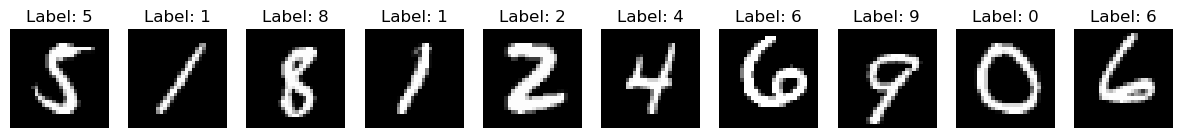

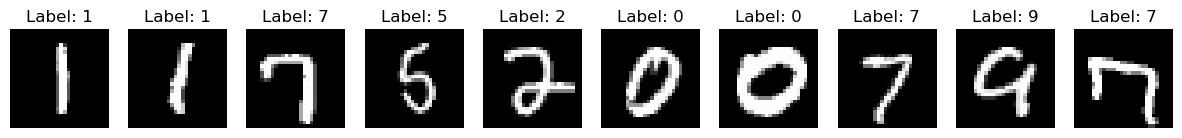

In [176]:
def visualize_samples(batch, num_samples=10):
    # Get a batch of data from the data loader
    images, labels = batch
    images = images.view(-1, 28, 28)  # Reshape images to 28x28
    
    # Plot the specified number of samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i].numpy(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

# Visualize samples from training and validation data loaders
visualize_samples(train_dl.one_batch())
visualize_samples(valid_dl.one_batch())


In [178]:
dls = DataLoaders(train_dl, valid_dl)

## Needed function

In [207]:
mnist_model = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

# mnist_model = nn.Sequential(
#     nn.Linear(28*28, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 10)
# )

mnist_model(train_dl.one_batch()[0]).shape

torch.Size([64, 10])

In [188]:
preds = mnist_model(train_dl.one_batch()[0])
targets = train_dl.one_batch()[1]

preds.shape, targets.shape

(torch.Size([64, 10]), torch.Size([64, 1]))

In [189]:
targets.view(-1)

tensor([5, 1, 8, 1, 2, 4, 6, 9, 0, 6, 9, 2, 0, 8, 4, 7, 5, 1, 5, 1, 1, 3, 3, 7,
        1, 3, 4, 5, 4, 6, 1, 7, 5, 0, 3, 7, 5, 6, 5, 2, 4, 3, 5, 1, 9, 5, 0, 9,
        5, 7, 3, 9, 2, 0, 9, 5, 1, 4, 8, 9, 0, 4, 6, 5])

In [200]:
def complete_mnist_loss(preds, targets):
    # preds = preds.softmax(1)
    # display(preds)
    # targets = targets.view(-1)
    # targets_probs = preds[range(targets.shape[0]), targets]

    # display(targets_probs)
    # return -torch.log(targets_probs).mean()

    # print(preds.shape, targets.shape)
    # print(targets * preds.log())
    # return -(targets * preds.log()).sum() / len(preds)
    return nn.functional.cross_entropy(preds, targets.squeeze())
    
random_preds = tensor([[0.9261, 0.7523, 0.7815, 0.5587, 0.9547, 0.3564, 0.9957, 0.5457, 0.9605,
         0.7544],
        [0.7494, 0.8851, 0.9722, 0.9944, 0.3382, 0.7579, 0.5753, 0.2673, 0.1166,
         0.3712],
        [0.0948, 0.6444, 0.0074, 0.1551, 0.0752, 0.8233, 0.2820, 0.0842, 0.5581,
         0.2289],
        [0.2603, 0.6603, 0.6184, 0.3055, 0.7156, 0.6018, 0.3889, 0.0617, 0.7188,
         0.6093],
        [0.6258, 0.9553, 0.1366, 0.4280, 0.8662, 0.4507, 0.7663, 0.3752, 0.7364,
         0.8468]])
display(random_preds)
random_targets = tensor([9, 5, 7, 4, 1])
display(random_targets)
complete_mnist_loss(random_preds, random_targets)

tensor([[0.9261, 0.7523, 0.7815, 0.5587, 0.9547, 0.3564, 0.9957, 0.5457, 0.9605,
         0.7544],
        [0.7494, 0.8851, 0.9722, 0.9944, 0.3382, 0.7579, 0.5753, 0.2673, 0.1166,
         0.3712],
        [0.0948, 0.6444, 0.0074, 0.1551, 0.0752, 0.8233, 0.2820, 0.0842, 0.5581,
         0.2289],
        [0.2603, 0.6603, 0.6184, 0.3055, 0.7156, 0.6018, 0.3889, 0.0617, 0.7188,
         0.6093],
        [0.6258, 0.9553, 0.1366, 0.4280, 0.8662, 0.4507, 0.7663, 0.3752, 0.7364,
         0.8468]])

tensor([9, 5, 7, 4, 1])

tensor(2.2334)

In [191]:
def complete_mnist_accuracy(preds, targets):
    preds = preds.argmax(dim=1)
    targets = targets.squeeze()
    correct = (preds == targets).float()
    return correct.float().mean()

random_preds = torch.rand((5, 10))
display(random_preds)
random_targets = torch.randint(0, 10, (5, 1))
display(random_targets)
complete_mnist_accuracy(random_preds, random_targets)

tensor([[0.5016, 0.6549, 0.4489, 0.3574, 0.1934, 0.4519, 0.5101, 0.3282, 0.5563,
         0.7822],
        [0.1934, 0.7311, 0.1284, 0.2372, 0.1636, 0.1245, 0.6112, 0.1970, 0.6230,
         0.9090],
        [0.9908, 0.7340, 0.9985, 0.5289, 0.6752, 0.8910, 0.0796, 0.4047, 0.4377,
         0.3398],
        [0.4219, 0.3908, 0.3633, 0.0650, 0.7911, 0.6046, 0.5971, 0.1385, 0.7142,
         0.2435],
        [0.5443, 0.8052, 0.0297, 0.0520, 0.4307, 0.1545, 0.8662, 0.0265, 0.4005,
         0.7004]])

tensor([[2],
        [3],
        [8],
        [9],
        [3]])

tensor(0.)

In [208]:

learner = MyLearner(dls, mnist_model, complete_mnist_loss, complete_mnist_accuracy)

learner.fit(20, 0.01)

Epoch Train_Loss Valid_Accuracy  Time
Train loops: 750
 00:    0.6603     0.8265   1.4740
Train loops: 750
 01:    0.3746     0.8720   1.7726
Train loops: 750
 02:    0.2854     0.8878   1.5143
Train loops: 750
 03:    0.2437     0.8944   1.4211
Train loops: 750
 04:    0.2190     0.8994   1.4380
Train loops: 750
 05:    0.2023     0.9033   1.4473
Train loops: 750
 06:    0.1900     0.9063   1.4664
Train loops: 750
 07:    0.1798     0.9096   1.8465
Train loops: 750
 08:    0.1713     0.9116   1.4552
Train loops: 750
 09:    0.1641     0.9136   1.7202
Train loops: 750
 10:    0.1577     0.9151   1.4715
Train loops: 750
 11:    0.1528     0.9173   1.4127
Train loops: 750
 12:    0.1488     0.9193   1.4349
Train loops: 750
 13:    0.1456     0.9213   1.5143
Train loops: 750
 14:    0.1424     0.9231   1.5981
Train loops: 750
 15:    0.1398     0.9247   1.4805
Train loops: 750
 16:    0.1371     0.9254   1.6357
Train loops: 750
 17:    0.1345     0.9265   1.4129
Train loops: 750
 18:    0

In [166]:
learner.predict(train_dl.one_batch()[0][0:5])

tensor([3, 1, 3, 1, 4, 4, 3, 0, 4, 0], device='cuda:0')

In [167]:
train_dl.one_batch()[1].squeeze(
)

tensor([9, 8, 9, 6, 3, 1, 3, 5, 9, 5, 1, 4, 3, 3, 6, 6, 6, 8, 9, 1, 7, 1, 5, 8,
        0, 5, 3, 5, 9, 9, 8, 2, 9, 8, 7, 0, 8, 0, 4, 4, 2, 1, 1, 7, 6, 2, 6, 8,
        5, 6, 2, 9, 6, 9, 7, 8, 0, 4, 1, 0, 7, 7, 6, 0], device='cuda:0')

In [169]:
mnist_model(train_dl.one_batch()[0]).argmax(dim=1)

tensor([9, 3, 9, 0, 3, 1, 3, 3, 9, 3, 1, 0, 3, 3, 3, 0, 6, 3, 9, 1, 7, 1, 3, 3,
        0, 3, 3, 2, 9, 9, 3, 0, 3, 3, 7, 0, 3, 3, 9, 0, 2, 1, 3, 7, 6, 2, 6, 3,
        3, 3, 3, 9, 3, 9, 3, 7, 0, 9, 3, 0, 7, 7, 0, 0], device='cuda:0')